In [2]:
import pandas as pd
import numpy as np
import json
import os
from helper import load_data, load_data_im2recipe
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import requests
from food_extractor.food_model import FoodModel
import seaborn as sns
import pickle

%load_ext autoreload
%autoreload 2

# - Load the data

## Yummly data

In [4]:
df_yummly = load_data(cache=False, lists_folder='../foodprint/data/lists/', recipes_folder='../foodprint/data/recipes/')
df_yummly.head()

,id,recipeName,ingredients
0,Sake-and-Ginger-Soba-Noodle-Salmon-Stir-Fry_-2...,Sake and Ginger Soba Noodle Salmon Stir Fry.,"[sake, low sodium soy sauce, fresh ginger, gar..."
1,Japanese-Teriyaki-Style-Glazed-Salmon-2036776,Japanese Teriyaki-Style Glazed Salmon,"[salmon fillets, sea salt, cracked black peppe..."
2,Salmon-teriyaki-308049,Salmon Teriyaki,"[salmon, soy sauce, mirin, sugar, vegetable oil]"
3,Honey-Teriyaki-Chicken-1038563,Honey Teriyaki Chicken,"[boneless skinless chicken thighs, honey, teri..."
4,Mirin-Glazed-Salmon-Once-Upon-A-Chef-200003,Mirin Glazed Salmon,"[mirin, light brown sugar, soy sauce, salmon f..."


In [3]:
df_yummly=pd.DataFrame()

## im2recipe data

### From source file

In [146]:
df_im2recipe_all = load_data_im2recipe(recipes_folder='../foodprint/data/im2recipes/')
df_im2recipe_all.head()

,id,recipeName,ingredients
0,000095fc1d,Yogurt Parfaits,"[yogurt greek plain nonfat, strawberries raw, ..."
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe","[sugars granulated, oil corn peanut and olive,..."
2,00059b093b,Honey Sriracha Chicken Wings,[chicken broilers or fryers wing meat and skin...
3,0005fc89f7,Shrimp and Caper Salad,[crustaceans shrimp raw (not previously frozen...
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,"[cocoa dry powder unsweetened, honey, peanut b..."


In [150]:
df_im2recipe = df_im2recipe_all.copy()

### From cache file

In [4]:
df_im2recipe = pickle.load(open('../foodprint/cached_data/cached_im2recipe.pickle','rb'))

In [5]:
df_im2recipe.shape

(51235, 5)

## Concat Yummly & im2recipe

In [85]:
df = pd.concat([df_yummly, df_im2recipe]).reset_index(drop=True)
print(df_yummly.shape)
print(df_im2recipe.shape)
print(df.shape)

(0, 0)
(51235, 5)
(51235, 5)


### Add CO2 & Nutritional data

In [86]:
df.head()

,id,recipeName,co2,ingredients,bow
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]","{'yogurt': 1, 'greek': 1, 'strawberries': 1, '..."
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute...","{'sugar': 1, 'oil corn peanut': 1, 'olive': 1,..."
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice...","{'chicken': 1, 'broil': 1, 'meat': 1, 'skin': ..."
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion...","{'crust': 1, 'aceans shrimp': 1, 'onions sprin..."
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]","{'cocoa dry powder': 1, 'honey': 1, 'peanut bu..."


In [87]:
df_co2 = pd.read_csv('../foodprint/data/dishes_with_co2_nutrients_2.csv')
print(df_co2.shape)
df_co2.head()

(51235, 13)


,id,dish_name,ingredients,weight_per_ingr,total_dish_weight,total_footprint,dish_footprint_per_100gr,confidence_score,dish_footprint_per_kilo,co2_score,km_driven_per_100gr,nutrients_per_100gr,proportion_of_ingredient
0,000095fc1d,Yogurt Parfaits,"['yogurt, greek, plain, nonfat', 'strawberries...","[226.796, 152.0, 30.5]",409.296000,0.522744,0.127718,1.000000,1.277178,low,0.494907,"{'energy': 81.12946131894766, 'fat': 2.1401392...","[0.5541124271920566, 0.3713693757085337, 0.074..."
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe","['sugars, granulated', 'oil, corn, peanut, and...","[100.80000000000001, 168.0, 21.25, 5.166666666...",747.808333,1.189488,0.159063,1.000000,1.590633,low,0.616370,"{'energy': 477.09640393594606, 'fat': 23.41248...","[0.13479389772334713, 0.2246564962055785, 0.02..."
2,00059b093b,Honey Sriracha Chicken Wings,"['chicken, broilers or fryers, wing, meat and ...","[1360.7759999999998, 6.0, 1.15, 13.5, 42.59999...",1579.409333,6.446860,0.408182,1.000000,4.081817,high,1.581704,"{'energy': 208.05898280960727, 'fat': 14.29704...","[0.8615727229673203, 0.0037988885296359742, 0...."
3,0005fc89f7,Shrimp and Caper Salad,"['crustaceans, shrimp, raw (not previously fro...","[907.184, 75.0, 151.5, 25.799999999999997, 134...",1574.431917,5.838564,0.370836,0.983613,3.708362,high,1.436990,"{'energy': 194.7525956849092, 'fat': 15.980767...","[0.5761976687570326, 0.0476362294273019, 0.096..."
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,"['cocoa, dry powder, unsweetened', 'honey', 'p...","[1032.0, 4068.0, 256.0]",5356.000000,4.367520,0.081544,0.807319,0.815444,low,0.315985,"{'energy': 303.43539955190437, 'fat': 5.094846...","[0.19268110530246452, 0.7595220313666916, 0.04..."


In [83]:
df = df.merge(df_co2[['id','dish_footprint_per_100gr']], on='id', how='inner')


In [84]:
df.rename(columns={'dish_footprint_per_100gr':'co2'}, inplace=True)
df.head()

,id,recipeName,co2,ingredients,bow,dish_footprint_per_100gr_x,dish_footprint_per_100gr_y,co2,co2,nutritional_value
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]","{'yogurt': 1, 'greek': 1, 'strawberries': 1, '...",0.127718,0.127718,0.127718,0.127718,2
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute...","{'sugar': 1, 'oil corn peanut': 1, 'olive': 1,...",0.159063,0.159063,0.159063,0.159063,17
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice...","{'chicken': 1, 'broil': 1, 'meat': 1, 'skin': ...",0.408182,0.408182,0.408182,0.408182,16
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion...","{'crust': 1, 'aceans shrimp': 1, 'onions sprin...",0.370836,0.370836,0.370836,0.370836,10
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]","{'cocoa dry powder': 1, 'honey': 1, 'peanut bu...",0.081544,0.081544,0.081544,0.081544,15


### Calculate nutri-score

In [91]:
import ast
df_co2['nutrients_per_100gr'] = df_co2['nutrients_per_100gr'].apply(lambda x :ast.literal_eval(x)) 
df_co2.iloc[1]['nutrients_per_100gr']

{'energy': 477.09640393594606,
 'fat': 23.412485931109796,
 'protein': 7.625491714677334,
 'salt': 0.5486205522805532,
 'saturates': 3.4250537682338384,
 'sugars': 14.298442949953758}

In [92]:
df_nutri = df_co2[['id','nutrients_per_100gr']]
df_nutri.head()

,id,nutrients_per_100gr
0,000095fc1d,"{'energy': 81.12946131894766, 'fat': 2.1401392..."
1,00051d5b9d,"{'energy': 477.09640393594606, 'fat': 23.41248..."
2,00059b093b,"{'energy': 208.05898280960727, 'fat': 14.29704..."
3,0005fc89f7,"{'energy': 194.7525956849092, 'fat': 15.980767..."
4,0006ca31f4,"{'energy': 303.43539955190437, 'fat': 5.094846..."


In [93]:
vect_nutri = DictVectorizer(sparse=False)
X_nutri = vect_nutri.fit_transform(df_nutri.nutrients_per_100gr.tolist())

In [94]:
vect_nutri.feature_names_

['energy', 'fat', 'protein', 'salt', 'saturates', 'sugars']

In [95]:
def energy_score(x):
    x_joul = x*4.18
    levels = [335,670,1005,1340,1675,2010,2345,2680,3015,3350]
    scores = [0,1,2,3,4,5,6,7,8,9]
    for level, score in zip(levels,scores):
        if x_joul < level:
            return score
    return 10

def sugar_score(x):
    levels = [4.5,9,13.5,18,22.5,27,31.5,36,40,45]
    scores = [0,1,2,3,4,5,6,7,8,9]
    for level, score in zip(levels,scores):
        if x < level:
            return score
    return 10

def salt_score(x):
    x_mg = x*1000
    levels = [90,180,270,360,450,540,630,720,810,900]
    scores = [0,1,2,3,4,5,6,7,8,9]
    for level, score in zip(levels,scores):
        if x_mg < level:
            return score
    return 10

def saturates_score(x):
    levels = [1,2,3,4,5,6,7,8,9,10]
    scores = [0,1,2,3,4,5,6,7,8,9]
    for level, score in zip(levels,scores):
        if x < level:
            return score
    return 10

In [96]:
df_nutrition = pd.DataFrame(X_nutri, columns=vect_nutri.feature_names_, index=df_nutri.id).drop(columns=['fat','protein'])
df_nutrition['energy'] = df_nutrition['energy'].apply(lambda x : energy_score(x))
df_nutrition['sugars'] = df_nutrition['sugars'].apply(lambda x : sugar_score(x))
df_nutrition['salt'] = df_nutrition['salt'].apply(lambda x : salt_score(x))
df_nutrition['saturates'] = df_nutrition['saturates'].apply(lambda x : saturates_score(x))
df_nutrition['nutritional_value'] = df_nutrition.sum(axis=1)
df_nutrition = df_nutrition.reset_index()
df_nutrition.head()

,id,energy,salt,saturates,sugars,nutritional_value
0,000095fc1d,1,0,0,1,2
1,00051d5b9d,5,6,3,3,17
2,00059b093b,2,10,4,0,16
3,0005fc89f7,2,6,2,0,10
4,0006ca31f4,3,0,2,10,15


In [97]:
df = df.merge(df_nutrition[['id','nutritional_value']], on='id', how='inner')

In [98]:
df.head()

,id,recipeName,co2,ingredients,bow,nutritional_value
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]","{'yogurt': 1, 'greek': 1, 'strawberries': 1, '...",2
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute...","{'sugar': 1, 'oil corn peanut': 1, 'olive': 1,...",17
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice...","{'chicken': 1, 'broil': 1, 'meat': 1, 'skin': ...",16
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion...","{'crust': 1, 'aceans shrimp': 1, 'onions sprin...",10
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]","{'cocoa dry powder': 1, 'honey': 1, 'peanut bu...",15


# - Clean the ingredients

## FoodBert

In [33]:
model = FoodModel("chambliss/distilbert-for-food-extraction")

In [157]:
df_cleaned = df.copy()

In [158]:
df_cleaned['ingredients2'] = df_cleaned['ingredients'].apply(lambda x : \
                                                                     [ing['text'] for ing in model.extract_foods(','.join([ing for ing in x]))[0]['Ingredient']])


In [159]:
df_cleaned.drop(columns=['ingredients'], inplace=True)
df_cleaned.rename(columns={'ingredients2':'ingredients'}, inplace=True)
print(df_cleaned.shape)
df_cleaned.head(-10)

(51235, 4)


,id,recipeName,co2,ingredients
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]"
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute..."
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice..."
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion..."
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]"
...,...,...,...,...
51220,ffefad6dcc,Pumpkin-raisin Cookies,0.204514,"[wheat flour, sugars, powder, sodium aluminum ..."
51221,fff06938d1,Mother's Sticky Roasted Chicken (Cajun),0.318114,"[salt, spices paprika, spices pepper red, caye..."
51222,fff1025216,Country Dijon Salad Dressing,0.182401,"[yellow, apple juice, sugars, parsley, spices ..."
51223,fff2c7c05d,Zesty Mashed Potatoes,0.181304,"[skin, soymilk, vanilla, horseradish, oil canola]"


In [160]:
df = df_cleaned.copy()

In [161]:
df.head()

,id,recipeName,co2,ingredients
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]"
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute..."
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice..."
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion..."
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]"


## Food Categorization

In [162]:
df_ingredients = df[['ingredients']]

In [163]:
df_ingredients.head()

,ingredients
0,"[yogurt, greek, strawberries, cereals, granola]"
1,"[sugar, oil corn peanut, olive, egg substitute..."
2,"[chicken, broil, meat, skin, salt table, spice..."
3,"[crust, aceans shrimp, onions spring, scallion..."
4,"[cocoa dry powder, honey, peanut butter, salt]"


In [164]:
df_ingredients['bow'] = df_ingredients.ingredients.apply(convert_to_dict)
vect_test = DictVectorizer(sparse=False)
vect_test.fit(df_ingredients.bow.tolist())

/tmp/ipykernel_434/228694153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ingredients['bow'] = df_ingredients.ingredients.apply(convert_to_dict)


DictVectorizer(sparse=False)

In [165]:
ingredients = pd.DataFrame(vect_test.feature_names_)

In [166]:
ingredients.shape

(1390, 1)

# Pipeline

## - Convert ingredients into dict

In [22]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a] = 1
    return d

In [16]:
df['name_and_ing'] = df['ingredients'].apply(lambda x : x.insert(0,'a'))
df['name_and_ing']

0        None
1        None
2        None
3        None
4        None
         ... 
51230    None
51231    None
51232    None
51233    None
51234    None
Name: name_and_ing, Length: 51235, dtype: object

In [23]:
# First we create a bag of words per recipe
df['bow'] = df.ingredients.apply(convert_to_dict)
df.head()

,id,recipeName,co2,ingredients,bow
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]","{'yogurt': 1, 'greek': 1, 'strawberries': 1, '..."
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute...","{'sugar': 1, 'oil corn peanut': 1, 'olive': 1,..."
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice...","{'chicken': 1, 'broil': 1, 'meat': 1, 'skin': ..."
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion...","{'crust': 1, 'aceans shrimp': 1, 'onions sprin..."
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]","{'cocoa dry powder': 1, 'honey': 1, 'peanut bu..."


## Pipeline

### Find he number of components

In [109]:
def find_n_components(df):
    import numpy as np 
    vect_test = DictVectorizer(sparse=False)
    X_test = vect_test.fit_transform(df.bow.tolist())
    pca_test = PCA(n_components=min(df.shape[0], X_test.shape[1]))
    pca_test.fit(X_test)
    n_components = np.argmax(pca_test.explained_variance_ratio_.cumsum() > 0.9)
    return n_components

In [110]:
n_components = find_n_components(df)
n_components

241

### Create Pipeline

In [111]:
def pipeline(n_components):
    pipe = Pipeline([
        ('dict_vectorizer', DictVectorizer(sparse=False)),
        ('pca', PCA(n_components=n_components))
    ])
    return pipe

In [112]:
pipe = pipeline(n_components)
X = pipe.fit_transform(df.bow.tolist())
X.shape

(51235, 241)

# - Nearest Neighbor modeling

In [113]:
index_recipe = 51220
n_neighbors = 5

nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(X)
X_test = X[index_recipe].reshape(-1,1).T
neighbors = nn.kneighbors(X=X_test, n_neighbors=n_neighbors, return_distance=True)

In [114]:
X_test.shape

(1, 241)

In [115]:
dict_to_plot = {
    'name':[],
    'distance':[], 
    'co2':[],
    'marker_size':[]
}

for rec in zip(neighbors[0][0], neighbors[1][0]):
    dict_to_plot['name'].append(df.iloc[rec[1]]['recipeName'])
    dict_to_plot['distance'].append(rec[0])
    dict_to_plot['co2'].append(df.iloc[rec[1]]['co2'])
    dict_to_plot['marker_size'].append(df.iloc[rec[1]]['co2']*10000)

df_to_plot = pd.DataFrame(dict_to_plot)
df_to_plot

,name,distance,co2,marker_size
0,Pumpkin-raisin Cookies,0.000000,0.204514,2045.139719
1,Cinnamon Raisin Bread,2.206736,0.117785,1177.849721
2,Soft Drop Sugar Cookie Mix,2.210210,0.162434,1624.340991
3,Holiday Raisin Shortbread Bars,2.210677,0.116182,1161.821019
4,"Old Sog (An Eggless, Milkless Raisin Cake)",2.210901,0.108000,1080.003311


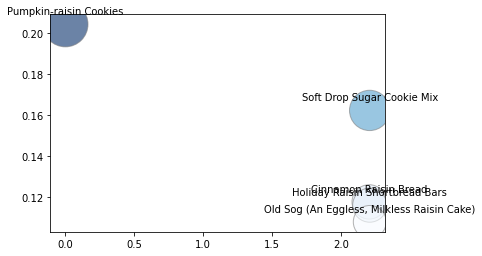

In [116]:
plt.scatter(df_to_plot['distance'], 
            df_to_plot['co2'], 
            s=df_to_plot['marker_size'], 
            c=df_to_plot['marker_size'], 
            cmap="Blues", 
            alpha=0.6, 
            edgecolors="grey", 
            linewidth=1, 
            label=df_to_plot['name'])

for x,y,z in zip(df_to_plot['distance'],df_to_plot['co2'],df_to_plot['name']):
    
    label = f"{z}"
    
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Nearest neighbors with c02 filtering

### Create Pipeline

def pipeline(n_components):
    pipe = Pipeline([
        ('dict_vectorizer', DictVectorizer(sparse=False)),
        ('pca', PCA(n_components=n_components))
    ])
    return pipe

pipe = pipeline(n_components)
pipe.fit(df.bow.tolist())

sample_test = 
df_filtered = df[df['co2']]
X2 = pipe.transform(df.bow.tolist())

# Export the data

## Export the data

### im2recipe dataframe

In [102]:
with open("../foodprint/cached_data/cached_im2recipe.pickle", "wb") as file:
    pickle.dump(df, file)

### Vectorized dataframe

In [117]:
with open("../foodprint/cached_data/cached_vectorized_data.pickle", "wb") as file:
    pickle.dump(pd.DataFrame(X, index=df.id), file)

### Informational dataframe

In [118]:
with open("../foodprint/cached_data/cached_informational_data.pickle", "wb") as file:
    pickle.dump(df, file)

## Export the pipeline

In [119]:
with open("../foodprint/cached_data/pipeline.pickle", "wb") as file:
    pickle.dump(pd.DataFrame(X, index=df.id), file)

## Exporte the model

In [120]:
# Export pipeline as pickle file
with open("../models/nneighbors_model.pkl", "wb") as file:
    pickle.dump(nn, file)

# Test All

### Id is provided

In [121]:
id = 'ffefad6dcc'

### load the vectorized data

In [122]:
# Load dataframe from pickle file
df_loaded = pickle.load(open("../foodprint/cached_data/cached_vectorized_data.pickle","rb"))

In [123]:
df_loaded.head()

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
id,,,,,,,,,,,,,,,,,,,,,
000095fc1d,-0.661828,-0.500181,0.030801,0.066482,-0.188247,-0.037580,-0.189542,-0.145224,-0.163167,-0.042780,...,-0.008525,-0.152842,-0.180305,-0.252272,-0.167084,-0.070002,0.209402,-0.187581,-0.017007,-0.005935
00051d5b9d,-0.051442,-0.167559,0.389512,-0.226786,-0.919618,0.588155,-1.012921,-0.230566,0.107573,-0.187467,...,-0.002405,-0.006475,-0.021159,-0.011106,0.004805,-0.005419,0.011783,0.014265,-0.010349,0.004190
00059b093b,0.171450,1.004136,-0.877200,0.452990,-0.118462,0.221703,0.860022,0.192291,-0.053758,0.424463,...,-0.005538,-0.047804,0.057223,-0.101198,-0.011549,0.049943,0.108129,-0.063694,-0.031750,-0.047776
0005fc89f7,-0.871274,-0.090335,0.001575,-0.000387,-0.137020,0.445409,0.453396,-0.178838,-0.350404,-0.022536,...,0.009341,-0.018173,0.043498,0.028645,-0.018439,0.015544,0.016874,0.034936,-0.019899,-0.004639
0006ca31f4,-0.044486,-0.500178,-0.382693,0.368478,-0.350625,-0.015668,0.203325,0.208659,0.289014,0.194988,...,0.011602,0.004649,-0.004291,0.002015,0.003971,0.002350,-0.014917,0.013470,-0.007408,0.000726


In [124]:
np.array(df_loaded).shape

(51235, 241)

In [127]:
### Load the informational data

In [128]:
df_info = pickle.load(open("../foodprint/cached_data/cached_informational_data.pickle","rb"))

In [129]:
df_info.head()

,id,recipeName,co2,ingredients,bow,nutritional_value
0,000095fc1d,Yogurt Parfaits,0.127718,"[yogurt, greek, strawberries, cereals, granola]","{'yogurt': 1, 'greek': 1, 'strawberries': 1, '...",2
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe",0.159063,"[sugar, oil corn peanut, olive, egg substitute...","{'sugar': 1, 'oil corn peanut': 1, 'olive': 1,...",17
2,00059b093b,Honey Sriracha Chicken Wings,0.408182,"[chicken, broil, meat, skin, salt table, spice...","{'chicken': 1, 'broil': 1, 'meat': 1, 'skin': ...",16
3,0005fc89f7,Shrimp and Caper Salad,0.370836,"[crust, aceans shrimp, onions spring, scallion...","{'crust': 1, 'aceans shrimp': 1, 'onions sprin...",10
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,0.081544,"[cocoa dry powder, honey, peanut butter, salt]","{'cocoa dry powder': 1, 'honey': 1, 'peanut bu...",15


### Get the recipe

In [125]:
recipe = np.array(df_loaded.loc[id]).reshape(-1,1).T

In [126]:
recipe.shape

(1, 241)

### Load the model

In [209]:
# Load model from pickle file
nn_loaded = pickle.load(open("../models/nneighbors_model.pkl","rb"))

### find the neighbors

In [210]:
n_neighbors = 5
neighbors = nn_loaded.kneighbors(X=recipe, n_neighbors=n_neighbors, return_distance=True)

In [211]:
neighbors

(array([[0.        , 2.20439266, 2.20704846, 2.20832353, 2.20858717]]),
 array([[51220, 28218, 40140,  2497, 36537]]))